In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def f(x):
    return 3*x**2 - 4*x+5

f(3.0)

20.0

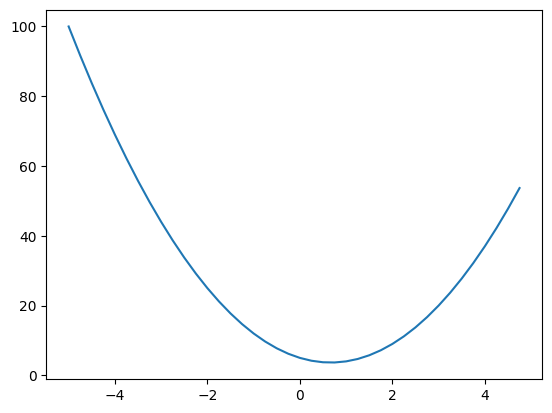

In [8]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.001
x = 3.0
(f(x+h) - f(x)) / h

14.00300000000243

In [10]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d) 

4.0


In [11]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
a += h
d2 = a*b + c
print("d1", d1)
print("d2", d2)
print("slope : ", (d2 - d1) / h)
 

d1 4.0
d2 3.999699999999999
slope :  -3.000000000010772


In [491]:
class Value:
    def __init__(self, data, _children = (), _op = "", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(Data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out = Value(self.data + other.data, (self, other), "+")
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self - other
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out = Value(self.data * other.data, (self, other), "*")
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (float, int)), "only supporting float and int"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other):
        return self * other ** -1 
    
    def __rtruediv__(self, other):
        return self / other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def relu(self):
        x = max(0, self.data)
        out = Value(x, (self, ), "relu")

        def _backward():
            if x == 0:
                self.grad += 0 * out.grad
            else:
                self.grad += 1 * out.grad

        out._backward = _backward
        return out
    
    def backward(self):

        # topological sort
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label= "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d+f; L.label = "L"
print(L)

a = 1/a
print(a)


Value(Data=2.0)
Value(Data=2.0)


In [492]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges



def draw_dot(root):
    dot = Digraph(format = "svg", graph_attr = {"rankdir" : "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape = "record")

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

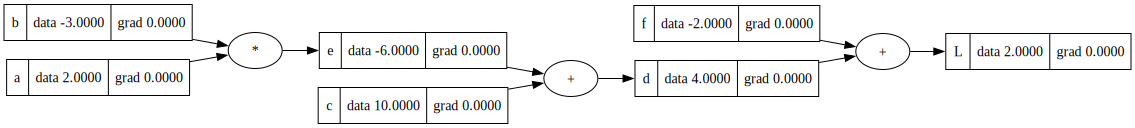

In [493]:
draw_dot(L)

In [494]:
# inputs x1, x2

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

# bias
b = Value(6.8813795880195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh(); o.label = "o"

o.grad = 1.0
o.backward()

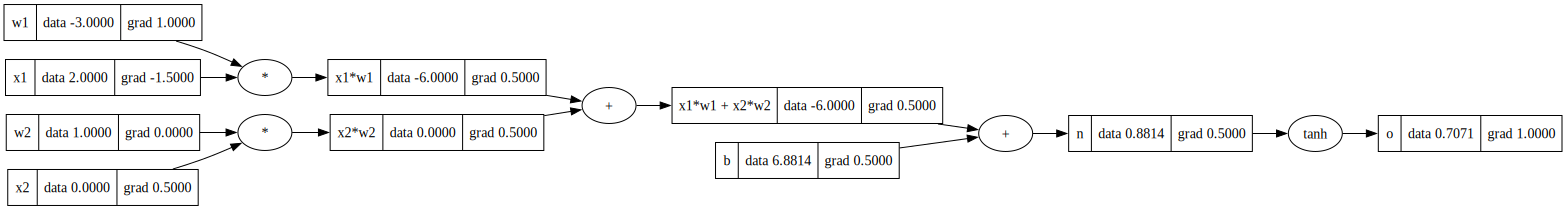

In [495]:
draw_dot(o)

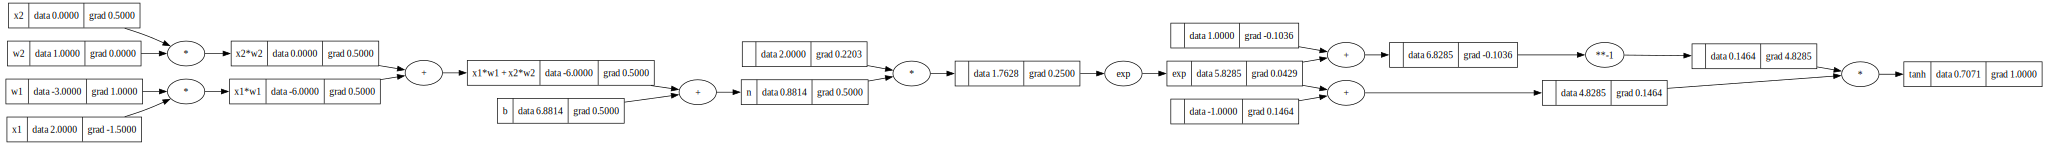

In [496]:
# inputs x1, x2

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label="x2")

# weights w1, w2
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

# bias
b = Value(6.8813795880195432, label="b")

x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"

e = (2*n).exp(); e.label = "exp"
o = (e - 1) / (e + 1); o.label = "tanh"

# o = n.tanh(); o.label = "o"

o.grad = 1.0
o.backward()
draw_dot(o)

In [497]:
# doing the same using pytorch
import torch

x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()      ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True

b = torch.Tensor([6.8813795880195432]).double() ; b.requires_grad = True    
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("x1 : ", x1.grad.item())
print("x2 : ", x2.grad.item())
print("w1 : ", w1.grad.item())
print("w2 : ", w2.grad.item())


0.7071097898337744
x1 :  -1.4999872353637063
x2 :  0.49999574512123546
w1 :  0.9999914902424709
w2 :  0.0


In [507]:
import random

class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

        def parameters(self):
            return []

class Neuron(Module):
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer(Module):
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP(Module):
    def __init__(self, nin, nouts = []):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(Data=0.21789547988451627)

In [508]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]



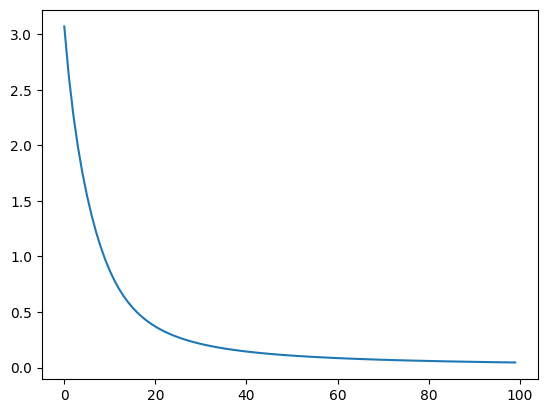

In [509]:
import matplotlib.pyplot as plt

losses = []

for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    losses.append(loss.data)

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update the values
    for p in n.parameters():
        p.data += -0.01 * p.grad


plt.plot(losses)
plt.show()




In [510]:
import random 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [511]:
np.random.seed(1337)
random.seed(1337)


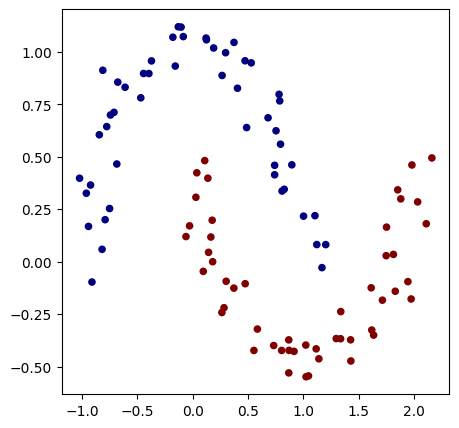

In [512]:
# make the dataset

from sklearn.datasets import make_moons, make_blobs
x, y = make_moons(n_samples = 100, noise = 0.1)

y = y*2 - 1

# visualize in 2d
plt.figure(figsize=(5,5))
plt.scatter(x[:, 0], x[:, 1], c = y, s = 20, cmap = "jet")

In [513]:
# init the model

model = MLP(2, [16, 16, 1])
print("number of parameters : ", len(model.parameters()))

number of parameters :  337


In [514]:
def loss(batch_size=None):
    if batch_size is None:
        xb, yb = x, y
    else:
        ri = np.random.permutation(x.shape[0])[:batch_size]
        xb, yb = x[ri], y[ri]

    inputs  = (list(map(Value, xrow)) for xrow in xb)

    # forward pass
    scores = list(map(model, inputs))

    # svm max-margin loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 Regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss


    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)




Value(Data=0.7840043023159258) 0.68


In [520]:
# optimization

for k in range(100):

    # foward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k / 100

    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.06676731357953536, accuracy 99.0%
step 10 loss 0.09262010182081841, accuracy 97.0%
step 20 loss 0.06790768602917993, accuracy 97.0%
step 30 loss 0.029605258328400625, accuracy 100.0%
step 40 loss 0.026990095862143907, accuracy 100.0%
step 50 loss 0.02542441176413096, accuracy 100.0%
step 60 loss 0.024372014504719958, accuracy 100.0%
step 70 loss 0.023645220647492873, accuracy 100.0%
step 80 loss 0.02314513572662035, accuracy 100.0%
step 90 loss 0.022814864290544138, accuracy 100.0%


(-1.548639298268643, 1.951360701731357)

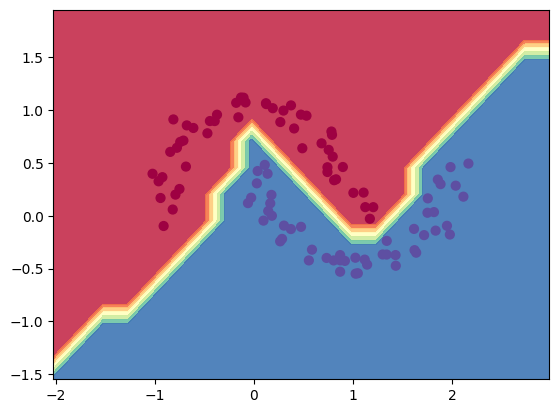

In [521]:
# visualize the decision boundary

h = 0.25
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in xmesh]
scores = list(map(model, inputs))

z = np.array([s.data > 0 for s in scores])
z = z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, z, cmap=plt.cm.Spectral, alpha = 0.9)
plt.scatter(x[:, 0], x[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
